-------------------------------------------------------------------
# Homework set 5 - solution

 * **Author**: Balint Szoke
 * **UniID**: bs2574

> This notebook shows downward bias in the OLS estimate of the correlation 
coefficient in an AR(1) regression. In addition, it demonstrates the power of `numba` in making loops run faster

-------------------------------------------------------------------


In [1]:
using Distributions: Normal
using PyPlot

## (1) Downward bias in the OLS estimate of the correlation coefficient in AR(1)

Consider the simple AR(1) process

$$X_{t+1} = \beta + \alpha X_{t} + \sigma W_{t+1}\hspace{1cm}W_{t+1}\sim\mathcal{N}(0,1)$$

and use OLS to estimate the parameter $\alpha$ from a given sample size $N$

In order to calculate the bias, we have to simulate a lot. Becuase this part is the slowest, it makes sense to write a separate function for this task that we can later pass on to numba. 

In [2]:
function sample_path(alpha::Real, beta::Real, sigma::Real, N::Int, x0=Union{})
    """
    Simulates the sample path for X of length N+1 starting from a specified initial value OR if x0 
    is None, it initializes the path with a draw from the stationary distribution of X. 
    
    Arguments
    -----------------
        alpha         : slope coefficient 
        beta          : intercept term
        sigma         : standard deviation of the error
        N             : length of the sample path without x0
        x0            : initial value of X
    
    Return:
    -----------------
        x_path (Vector): simulated path
        
    """
    if x0 == Union{}
        # Draw the initial value from the stationary distribution
        mean_erg = beta / (1 - alpha)
        stdev_erg = sigma / sqrt(1 - alpha^2) 
        x0 = rand(Normal(mean_erg, stdev_erg))
    end
    
    # Memory:
    x_path = Array{Float64}(N+1)
    x_path[1] = x0
    w_path = rand(Normal(0, 1), N)
    
    for t in range(1, N)
        x_path[t + 1] = beta + alpha * x_path[t] + sigma * w_path[t]
    end
    
    return x_path 
end

sample_path (generic function with 2 methods)

In [3]:
function ols_estimate(x_path::Array{Float64})
    """
    This function takes the sample path for X and calculates the OLS estimate for the correlation coefficient
    for the AR(1) model. 
    """
    N = length(x_path) - 1
    # Define the left (y=X_{t+1})  and right hand side variables (x = X_t) 
    y, x = x_path[2:end], x_path[1:end-1]
    
    sum_yx = (y' * x)[1] 
    sum_xx = (x' * x)[1] 
    sum_x = sum(x)
    sum_y = sum(y)
    return (sum_yx - (sum_x * sum_y)/N )/(sum_xx - (sum_x * sum_x)/N)
end

ols_estimate (generic function with 1 method)

Approximate the bias, which is defined as

$$ \mathbb{E}[\hat{\alpha}_N] - \alpha$$

where $\hat{\alpha}_N$ denotes the OLS estimate for the autoregressive coefficient for a sample size $N$. Downward bias means $ \mathbb{E}[\hat{\alpha}_N] < \alpha$, i.e. we expect this number to be negative.

In [4]:
function bias(M::Int, alpha::Real, beta::Real, sigma::Real, N::Int)
    """
    This function approximates the bias by drawing M simulations 
    for a given set of parameters (alpha, beta, sigma) and for a given sample size N
    """
    alpha_hats = Array{Float64}(M)
    for j in range(1, M)
        alpha_hats[j] = ols_estimate(sample_path(alpha, beta, sigma, N))
    end
    
    return mean(alpha_hats) - alpha 
end

bias (generic function with 1 method)

Let's study how fast are these so far

In [5]:
N, M = 500, 100000               # largest sample size and a relatively large number to get good approx
xx = sample_path(.5, 1., 1., N)   # sample path to test ols_estimate 

@time sample_path(.5, 1., 1., N)
@time ols_estimate(xx)
@time bias(M, .5, 1., 1., N)      # this is pretty fast (even compared to numba approx 3.6 sec)


  0.000017 seconds (151 allocations: 18.151 KB)
  0.047384 seconds (65.62 k allocations: 2.852 MB)
  

-0.005263366185614127

Investigate the properties of the estimator by plotting the bias for different sample sizes and different (true) `alpha` values.

In [6]:
alphas = [.5, .6, .7, .8, .9]                 # possible alphas
sample_sizes = 50:50:550                      # possible sample sizes

50:50:550

In [7]:
row, col = length(alphas), length(sample_sizes)
data = Array{Float64}(row, col)
@elapsed( 
for (i, a) in enumerate(alphas)
    for (j, n) in enumerate(sample_sizes)
        data[i,j] = bias(10000, a, 1.0, 1.0, round(Int, n))
    end
end
)

1.107804 seconds (903.34 k allocations: 1.542 GB, 7.70% gc time)


3.94838404

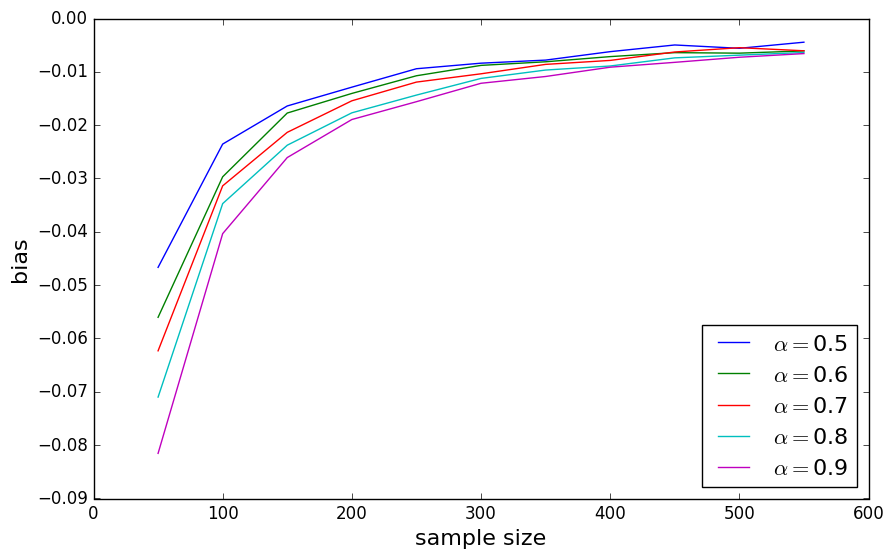

PyObject <matplotlib.text.Text object at 0x7f1ca8851a58>

In [8]:
fig, ax = subplots( figsize = (10, 6))

for (i, a) in enumerate(alphas)    
    ax[:plot](sample_sizes, reshape(data[i, :], col), label = L"$\alpha = $" * "$a")
end
ax[:legend](loc = "best", fontsize = 16)
ax[:set_ylabel]("bias", fontsize = 16)
ax[:set_xlabel]("sample size", fontsize = 16)

**Main lessons:**

- Not surprisingly, the approximate bias decreases with the sample size for any given $\alpha$, because the OLS estimator is consistent, hence the LLN must kick in (sooner or later). 

- On top of this, we can see that for any given sample size $N$, the (absolute value of) approximate bias increases as the true value of $\alpha$ is getting closer to $1$. Essentially, in the formula for the OLS estimator $\alpha$ multipies the covariance between $X_t$ and $W_{t+1}$ and this covariance is non-zero in the AR(1) model (this is exactly where the bias comes from).   
